In [1]:
# Import required modules
import datetime
from datetime import timedelta
import geopandas as gpd
import logging
%matplotlib notebook
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
from pprint import pprint
from shapely.geometry import Point
import sys
import warnings
import xarray as xr

# Add that all figures should be inlined
%matplotlib inline

## Read data

In [11]:
swe_observations_path = '/Users/dcasson/Data/snow_data/NorSWE/Bow_NorSWE.nc'
basin_gpkg_path = '/Users/dcasson/GitHub/PEMS/gis_data/bow/bow_boundary.gpkg'

In [12]:
# Read SWE station observations NetCDF
SWE_stations_ds = xr.open_dataset(swe_observations_path)

display(SWE_stations_ds)

<xarray.Dataset>
Dimensions:        (station_id: 43, time: 15706)
Coordinates:
  * time           (time) datetime64[ns] 1979-01-01 1979-01-02 ... 2021-12-31
  * station_id     (station_id) object 'CanSWE-ALE-05BA811' ... 'CanSWE-ALE-0...
Data variables: (12/14)
    lat            (station_id) float32 ...
    lon            (station_id) float32 ...
    elevation      (station_id) float32 ...
    source         (station_id) object ...
    station_name   (station_id) object ...
    type_mes       (station_id) uint8 ...
    ...             ...
    snd            (time, station_id) float32 ...
    den            (time, station_id) float32 ...
    data_flag_snw  (time, station_id) object ...
    data_flag_snd  (time, station_id) object ...
    qc_flag_snw    (time, station_id) object ...
    qc_flag_snd    (time, station_id) object ...
Attributes:
    Conventions:    CF-1.9
    Title:          Northern Hemisphere in situ SWE 1979-2021 v3
    Latest_update:  April 2025
    Source:         Environment and Climate Change Canada and partners (https...
    Distribution:   CanSWE data are redistributed under the Open Government L...
    Comment:        See Vionnet et al. (ESSD, 2021) for a description of the ...

In [17]:
# Convert SWE stations DataArray to GeoDataFrame for further analysis
data = {'station_id': SWE_stations_ds.station_id.data, 
        'station_name': SWE_stations_ds.station_name.data,
        'lon': SWE_stations_ds.lon.data, 
        'lat': SWE_stations_ds.lat.data} 
df = pd.DataFrame(data)
geometry = [Point(xy) for xy in zip(df['lon'], df['lat'])]
crs = "EPSG:4326"
SWE_stations_gdf = gpd.GeoDataFrame(df, crs=crs, geometry=geometry)

# Read basin shapefile
basins_gdf = gpd.read_file(basin_gpkg_path)
basins_gdf = basins_gdf.to_crs("EPSG:4326")
buffer_km_default =0
basin_id = 'bow'


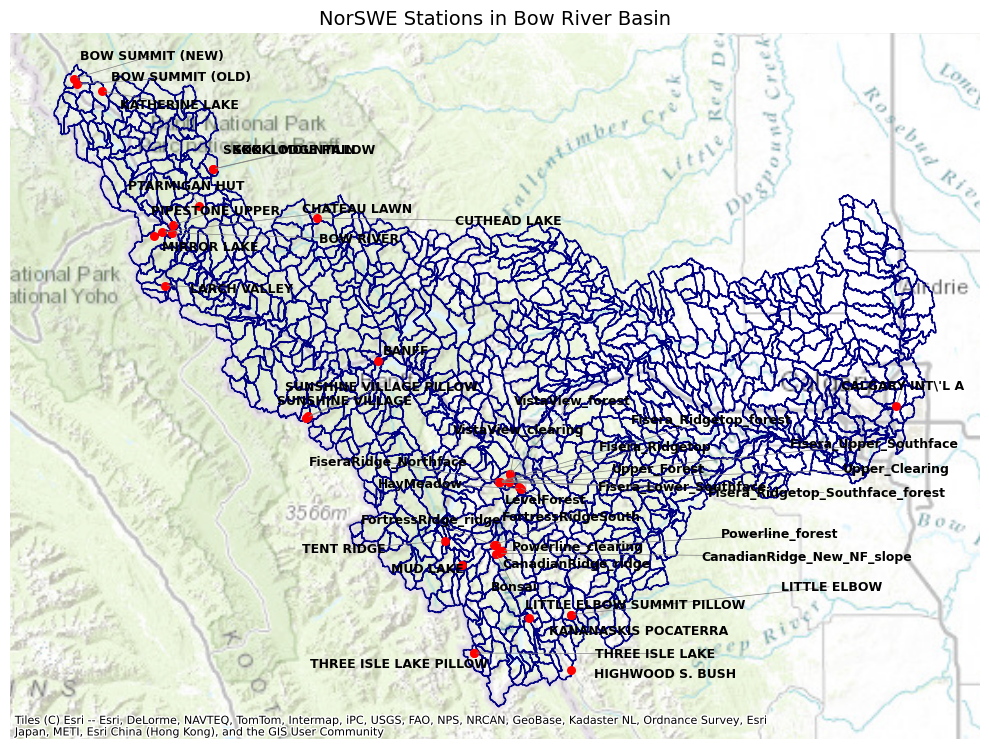

In [21]:
import geopandas as gpd
import matplotlib.pyplot as plt
import contextily as ctx
from adjustText import adjust_text  # pip install adjustText

# Load shapefiles
basins_gru_gdf = gpd.read_file('/Users/dcasson/Data/summa_snakemake/bow_tdx/watershed_tools/final/bow_tdx.gpkg')
# SWE_stations_gdf should already be loaded as a GeoDataFrame

# Project to Web Mercator for contextily
basins_gru_gdf_proj = basins_gru_gdf.to_crs(epsg=3857)
SWE_stations_gdf_proj = SWE_stations_gdf.to_crs(epsg=3857)

# Create the plot
fig, ax = plt.subplots(figsize=(10, 10))

# Plot the basin outlines
basins_gru_gdf_proj.plot(ax=ax, facecolor='none', edgecolor='navy', linewidth=1)

# Plot the SWE stations
SWE_stations_gdf_proj.plot(ax=ax, color='red', markersize=30, zorder=3)

# Use adjustText to reduce label overlap
texts = []
for x, y, label in zip(
        SWE_stations_gdf_proj.geometry.x, 
        SWE_stations_gdf_proj.geometry.y, 
        SWE_stations_gdf_proj['station_name']):
    texts.append(ax.text(x, y, label, fontsize=9, fontweight='bold', color='black', zorder=4))

adjust_text(texts, ax=ax, expand_points=(1.2, 1.6), arrowprops=dict(arrowstyle='-', color='gray', lw=0.5))

# Add a hydrology-friendly basemap (Stamen Terrain or ESRI World Topo)
ctx.add_basemap(
    ax, 
    crs=basins_gru_gdf_proj.crs.to_string(), 
    source=ctx.providers.Esri.WorldTopoMap,  # Or ctx.providers.Esri.WorldTopoMap
    alpha=0.8
)

ax.set_title('NorSWE Stations in Bow River Basin', fontsize=14)
ax.set_axis_off()
plt.tight_layout()
plt.show()

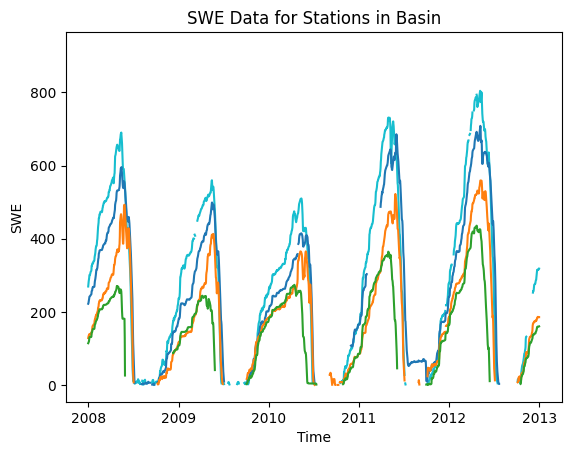

In [9]:
import matplotlib.pyplot as plt

# Iterate over each station in stations_in_basin
for station_id in SWE_stations_ds['station_id']:
        
        #Subset based on time 2020-01-01 to 2020-12-31
        SWE_stations_ds = SWE_stations_ds.sel(time=slice('2008-01-01', '2012-12-31'))
        # Get the snw data for the current station

        snw_data = SWE_stations_ds.sel(station_id=station_id)['snw']
        
        # Plot the snw data
        plt.plot(snw_data.time, snw_data, label=station_id)

# Set the plot title and labels
plt.title('SWE Data for Stations in Basin')
plt.xlabel('Time')
plt.ylabel('SWE')

# Add a legend
#plt.legend()

# Show the plot
plt.show()

You can zoom into the map with the rectangle icon ("zoom to rectangle") showing below the figure. Here, you see that the sample data contains SWE station observations for an area around two river basins, one in the USA and one in Canada, for which we also have all the data needed to run this workflow (e.g., discharge observations).

We will now extract the SWE station observations in the test basin and make a few plots.

/var/folders/46/6y3tkg051374dmsgd2w6l9gw0000gn/T/ipykernel_26997/2026905294.py:11: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout();


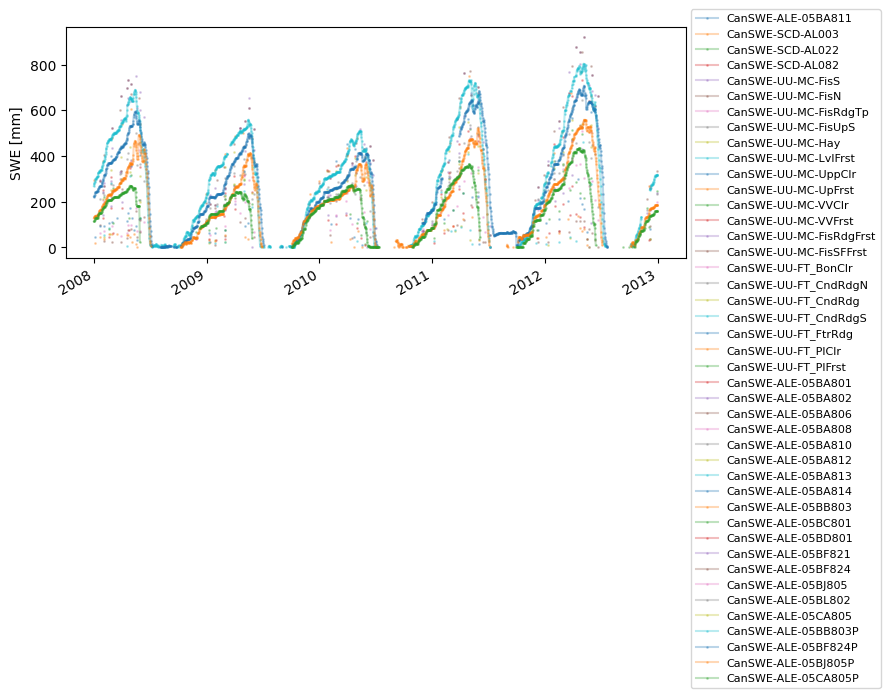

In [10]:
# Plot timeseries of SWE station observations in the test basin
fig = plt.figure(figsize=(8,3))

for s in SWE_stations_ds.station_id.values:
    SWE_stations_ds.snw.sel(station_id = s).plot(marker='o', alpha=.3, markersize=1, label=s)

plt.title('')
plt.ylabel('SWE [mm]')
plt.xlabel('')
plt.legend(bbox_to_anchor=(1,1.1), loc='upper left', fontsize=8)
plt.tight_layout();

/var/folders/46/6y3tkg051374dmsgd2w6l9gw0000gn/T/ipykernel_10720/1438024805.py:17: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout();


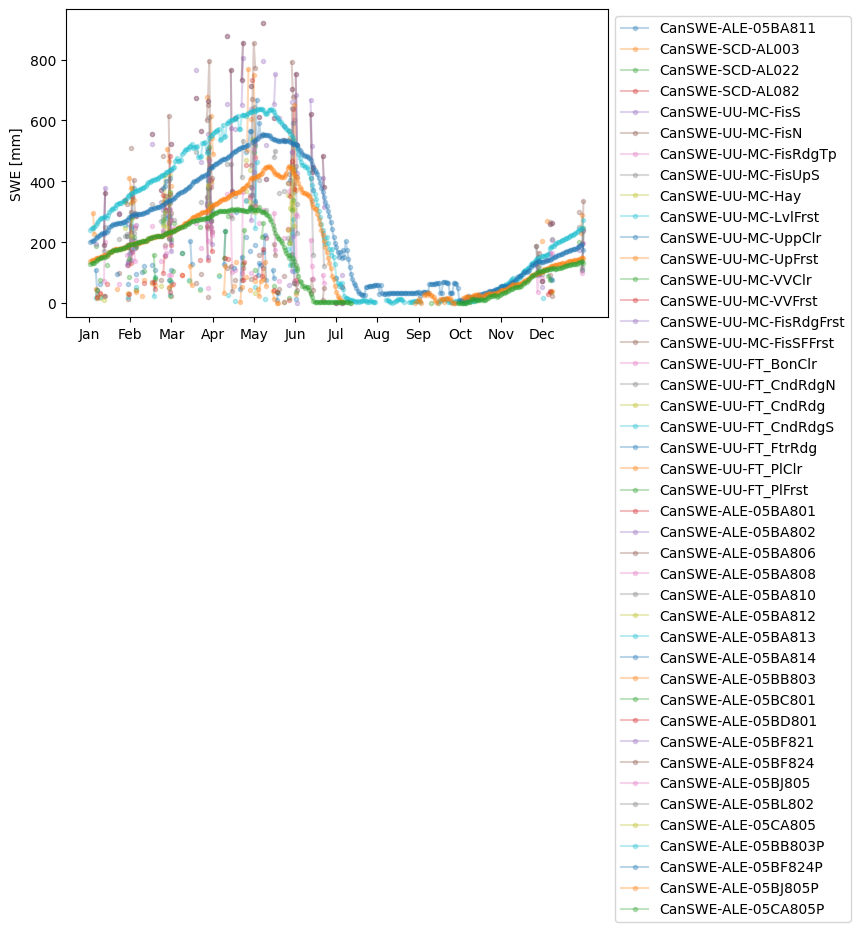

In [13]:
# Plot timeseries of test basin SWE observations climatological means
# We expect to see warnings as some days of the year only have missing values
with warnings.catch_warnings():
    warnings.simplefilter("ignore", category=RuntimeWarning)
    
    fig = plt.figure(figsize=(7,4))

    for s in SWE_stations_ds.station_id.values:
        testbasin_SWE_climatology_means = SWE_stations_ds.snw.sel(station_id = s).groupby("time.dayofyear").mean(dim=xr.ALL_DIMS, skipna=True)
        testbasin_SWE_climatology_means.plot(marker='o', alpha=.3, markersize=3, label=s)

    plt.title('')
    plt.xticks(np.linspace(0,366,13)[:-1], ('Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec'))
    plt.xlabel('')
    plt.ylabel('SWE [mm]')
    plt.legend(bbox_to_anchor=(1,1), loc='upper left')
    plt.tight_layout();

/Users/dcasson/Data/gpep/chena/summa_output/bow_007_timestep.nc
/Users/dcasson/Data/gpep/chena/summa_output/bow_002_timestep.nc
/Users/dcasson/Data/gpep/chena/summa_output/bow_008_timestep.nc
/Users/dcasson/Data/gpep/chena/summa_output/bow_001_timestep.nc
/Users/dcasson/Data/gpep/chena/summa_output/bow_004_timestep.nc
/Users/dcasson/Data/gpep/chena/summa_output/bow_003_timestep.nc
/Users/dcasson/Data/gpep/chena/summa_output/bow_006_timestep.nc
/Users/dcasson/Data/gpep/chena/summa_output/bow_010_timestep.nc
/Users/dcasson/Data/gpep/chena/summa_output/bow_005_timestep.nc
/Users/dcasson/Data/gpep/chena/summa_output/bow_009_timestep.nc


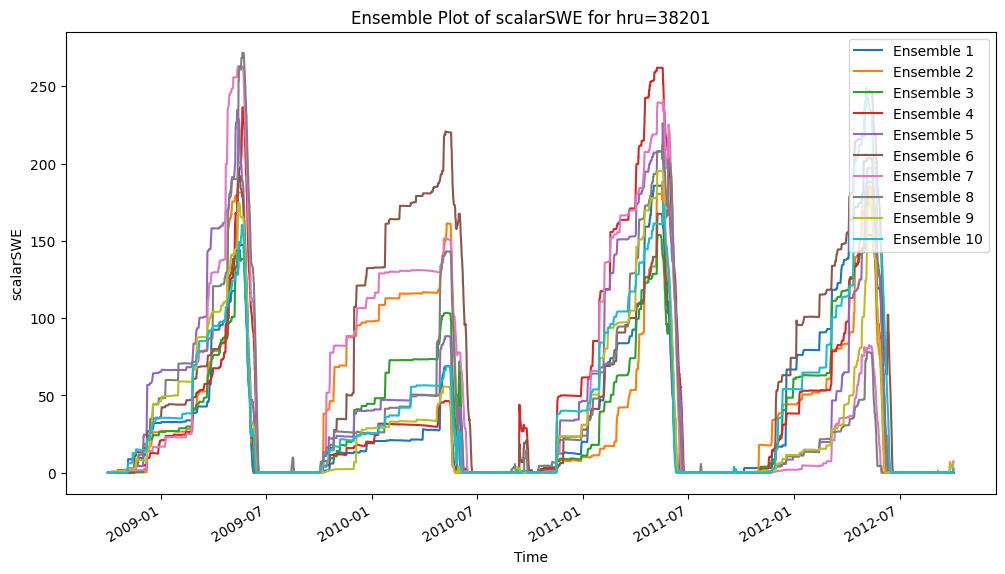

In [2]:
import os
import xarray as xr
import matplotlib.pyplot as plt

def plot_ensemble_from_directory(directory, variable_name, dimension_name, dimension_value):
    """
    Reads all NetCDF files in a directory and plots the user-defined variable
    for a specific dimension value from each file as an ensemble. The x-axis represents time.

    Parameters:
    - directory (str): Path to the directory containing NetCDF files.
    - variable_name (str): Name of the variable to plot.
    - dimension_name (str): Name of the dimension to filter.
    - dimension_value (int or str): Value of the dimension to filter.
    """
    # List to hold the datasets
    datasets = []

    # Read all NetCDF files in the directory
    for filename in os.listdir(directory):
        if filename.endswith('.nc'):
            filepath = os.path.join(directory, filename)
            ds = xr.open_dataset(filepath)
            print(filepath)
            datasets.append(ds)

    # Plot the variable for each dataset
    plt.figure(figsize=(12, 6))
    
    for ds in datasets:
        if variable_name in ds and dimension_name in ds.dims:
            ds_filtered = ds.sel({dimension_name: dimension_value})
            ds_filtered[variable_name].plot.line(x='time', add_legend=True)
    
    plt.title(f'Ensemble Plot of {variable_name} for {dimension_name}={dimension_value}')
    plt.xlabel('Time')
    plt.ylabel(variable_name)
    plt.legend([f'Ensemble {i+1}' for i in range(len(datasets))], loc='upper right')
    plt.show()

# Example usage:
# plot_ensemble_from_directory('/path/to/netcdf/files', 'prcp', 'hru', 1)

# Example usage:
path_to_results = '/Users/dcasson/Data/gpep/chena/summa_output/'
plot_ensemble_from_directory(path_to_results, 'scalarSWE', 'hru', 38201)

In [4]:
import os
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
from pathlib import Path
import numpy as np
import matplotlib.dates as mdates

def read_station_data(station_file, station_name):
    """
    Reads the station data from a NetCDF file for a specific station.

    Parameters:
    - station_file (str): Path to the NetCDF file containing station data.
    - station_name (str): Name of the station to read.

    Returns:
    - xarray.DataArray: DataArray for the specified station.
    """
    ds = xr.open_dataset(station_file)
    station_names = ds['station_name'].values
    if station_name in station_names:
        station_index = list(station_names).index(station_name)
        return ds.isel(station_id=station_index)['snw']
    else:
        raise ValueError(f"Station '{station_name}' not found in the file.")
    
def plot_ensemble_from_directory(directory, station_file, station_name, variable_name, dimension_name, dimension_value, output_path):
    """
    Reads all NetCDF files in a directory and plots the user-defined variable
    for a specific dimension value from each file as an ensemble. The x-axis represents time.

    Parameters:
    - directory (str): Path to the directory containing NetCDF files.
    - variable_name (str): Name of the variable to plot.
    - dimension_name (str): Name of the dimension to filter.
    - dimension_value (int or str): Value of the dimension to filter.
    - output_path (str): Path to save the output plot.
    """
    # List to hold the variable data for each ensemble member
    ensemble_data = []

    # Read the station data
    station_data = read_station_data(station_file, station_name)

    # Read all NetCDF files in the directory
    for filename in os.listdir(directory):
        if filename.endswith('.nc'):
            filepath = os.path.join(directory, filename)
            ds = xr.open_dataset(filepath)
            if variable_name in ds and dimension_name in ds.dims:
                ds_filtered = ds.sel({dimension_name: dimension_value})
                ensemble_data.append(ds_filtered[variable_name].values)

    # Convert ensemble data to a numpy array for easier manipulation
    ensemble_data = np.array(ensemble_data)
    
    # Calculate the required statistics
    max_envelope = np.max(ensemble_data, axis=0)
    min_envelope = np.min(ensemble_data, axis=0)
    p90_envelope = np.percentile(ensemble_data, 90, axis=0)
    p10_envelope = np.percentile(ensemble_data, 10, axis=0)

    # Plotting
    plt.figure(figsize=(12, 6))

    # Add the station data to the plot
    station_data.plot.scatter(x='time', color='black', linewidth=2, label=station_name)

    # Plot the envelopes
    time = ds_filtered['time'].values
    plt.fill_between(time, min_envelope, max_envelope, color='lightblue', alpha=0.3, label='Max-Min Envelope')
    plt.fill_between(time, p10_envelope, p90_envelope, color='blue', alpha=0.3, label='90-10 Percentile Envelope')

    plt.title(f'Ensemble Plot of {variable_name} for {dimension_name}={dimension_value}')
    plt.xlabel('Time')
    plt.ylabel(variable_name)
    plt.legend(loc='upper right')

    # Set the x-axis limits to the desired range of dates
    start_date = '2008-08-01'
    end_date = '2012-12-31'
    plt.xlim(mdates.datestr2num(start_date), mdates.datestr2num(end_date))

    plt.savefig(output_path)
    plt.close()

# Read the CSV file with stations and HRU_IDs
stations_with_hru_ids_file = '/Users/dcasson/Data/summa_snakemake/bow_tdx/stations_with_hru_ids.csv'
stations_df = pd.read_csv(stations_with_hru_ids_file)

# Directory containing NetCDF files
netcdf_directory = '/Users/dcasson/Data/snow_analysis/bow/gpep_output'
figure_directory = Path('/Users/dcasson/Data/summa_snakemake/bow_above_banff/swe_figures/')
station_file = '/Users/dcasson/Data/snow_data/NorSWE/Bow_NorSWE.nc'
figure_directory.mkdir(exist_ok=True)

# Iterate through each row in the CSV and create a plot for each HRU_ID and station pair
for index, row in stations_df.iterrows():
    station_name = row['station_name']
    hru_id = int(row['HRU_ID'])

    # Define the output path for the plot
    output_plot_path = f'{figure_directory}/ensemble_plot_{station_name}_HRU_{hru_id}.png'
    
    # Create the plot
    plot_ensemble_from_directory(netcdf_directory, station_file, station_name, 'scalarSWE', 'hru', hru_id, output_plot_path)

ValueError: zero-size array to reduction operation maximum which has no identity

In [7]:
import os
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
from pathlib import Path
import numpy as np
import matplotlib.dates as mdates

def read_station_data(station_file, station_name):
    ds = xr.open_dataset(station_file)
    station_names = ds['station_name'].values
    if station_name in station_names:
        station_index = list(station_names).index(station_name)
        return ds.isel(station_id=station_index)['snw']
    else:
        raise ValueError(f"Station '{station_name}' not found in the file.")

def read_casr_model_data(casr_model_file, variable_name, dimension_name, dimension_value):
    ds = xr.open_dataset(casr_model_file)
    # Use the same structure as ensemble files
    return ds.sel({dimension_name: dimension_value})[variable_name]

def plot_ensemble_from_directory(directory, station_file, station_name, variable_name, dimension_name, dimension_value, output_path, casr_model_file=None):
    ensemble_data = []

    # Read the station data
    station_data = read_station_data(station_file, station_name)

    # Read all NetCDF files in the directory
    for filename in os.listdir(directory):
        if filename.endswith('.nc'):
            filepath = os.path.join(directory, filename)
            ds = xr.open_dataset(filepath)
            if variable_name in ds and dimension_name in ds.dims:
                ds_filtered = ds.sel({dimension_name: dimension_value})
                ensemble_data.append(ds_filtered[variable_name].values)

    if len(ensemble_data) == 0:
        raise ValueError(f"No ensemble data found for {dimension_name}={dimension_value}")

    ensemble_data = np.array(ensemble_data)
    max_envelope = np.max(ensemble_data, axis=0)
    min_envelope = np.min(ensemble_data, axis=0)
    p90_envelope = np.percentile(ensemble_data, 90, axis=0)
    p10_envelope = np.percentile(ensemble_data, 10, axis=0)

    # Time for plotting (using last ds_filtered, which should be OK for axis)
    time = ds_filtered['time'].values
    time_num = mdates.date2num(pd.to_datetime(time))

    plt.figure(figsize=(12, 6))

    # Plot station data as black scatter points
    if 'time' in station_data.dims:
        x = pd.to_datetime(station_data['time'].values)
        y = station_data.values
        plt.scatter(x, y, color='black', s=18, label=station_name, zorder=10)
    else:
        raise ValueError("Expected 'time' dimension in station_data")

    # Plot the envelopes
    plt.fill_between(time_num, min_envelope, max_envelope, color='lightblue', alpha=0.3, label='Max-Min Envelope')
    plt.fill_between(time_num, p10_envelope, p90_envelope, color='blue', alpha=0.3, label='90-10 Percentile Envelope')

    # Optional: Plot CASR model data
    if casr_model_file is not None:
        casr_data = read_casr_model_data(casr_model_file, variable_name, dimension_name, dimension_value)
        casr_time = pd.to_datetime(casr_data['time'].values)
    plt.plot(casr_time, casr_data.values, color='orange', linewidth=2, label='CASR')

    plt.title(f'Ensemble Plot of {variable_name} for {station_name}')
    plt.xlabel('Time')
    plt.ylabel(variable_name)
    plt.legend(loc='upper right')

    start_date = '2008-08-01'
    end_date = '2012-12-31'
    plt.xlim(pd.to_datetime(start_date), pd.to_datetime(end_date))

    plt.savefig(output_path)
    plt.close()
            
# USAGE

stations_with_hru_ids_file = '/Users/dcasson/Data/summa_snakemake/bow_tdx/stations_with_hru_ids.csv'
stations_df = pd.read_csv(stations_with_hru_ids_file)
netcdf_directory = '/Users/dcasson/Data/snow_analysis/bow/gpep_output'
figure_directory = Path('/Users/dcasson/Data/summa_snakemake/bow_above_banff/swe_figures/')
station_file = '/Users/dcasson/Data/snow_data/NorSWE/Bow_NorSWE.nc'
casr_model_file = '/Users/dcasson/Data/snow_analysis/bow/casr_output/bow_casr_timestep.nc'  # <- Set this to your CASR file
figure_directory.mkdir(exist_ok=True)

for index, row in stations_df.iterrows():
    station_name = row['station_name']
    hru_id = int(row['HRU_ID'])
    output_plot_path = f'{figure_directory}/ensemble_plot_{station_name}_HRU_{hru_id}.png'
    plot_ensemble_from_directory(
        netcdf_directory, station_file, station_name,
        'scalarSWE', 'hru', hru_id, output_plot_path,
        casr_model_file=casr_model_file  # <--- add this arg
    )

In [12]:
import xarray as xr

def clip_netcdf_by_bounding_box(netcdf_file, output_file, lon_min, lat_min, lon_max, lat_max):
    """
    Clips the NetCDF file by the specified bounding box and maintains the station ID.

    Parameters:
    - netcdf_file (str): Path to the input NetCDF file.
    - output_file (str): Path to save the clipped NetCDF file.
    - lon_min (float): Minimum longitude for the bounding box.
    - lat_min (float): Minimum latitude for the bounding box.
    - lon_max (float): Maximum longitude for the bounding box.
    - lat_max (float): Maximum latitude for the bounding box.
    """
    # Load the NetCDF file
    ds = xr.open_dataset(netcdf_file)
    
    # Clip the dataset by the bounding box
    clipped_ds = ds.where(
        (ds['lon'] >= lon_min) & (ds['lon'] <= lon_max) &
        (ds['lat'] >= lat_min) & (ds['lat'] <= lat_max),
        drop=True
    )
    
    # Save the clipped dataset to a new NetCDF file
    clipped_ds.to_netcdf(output_file)
# Define the bounding box
lon_min = -117.5
lat_min = 50.25
lon_max = -114.5
lat_max = 52.25
netcdf_file = '/Users/dcasson/Data/gpep/from_hpc/all_station_data.nc'
output_file = '/Users/dcasson/Data/gpep/from_hpc/evaluation_stations_new.nc'
#clip_netcdf_by_bounding_box(netcdf_file, output_file, lon_min, lat_min, lon_max, lat_max)

eval_ds = xr.open_dataset(output_file)
print(eval_ds)

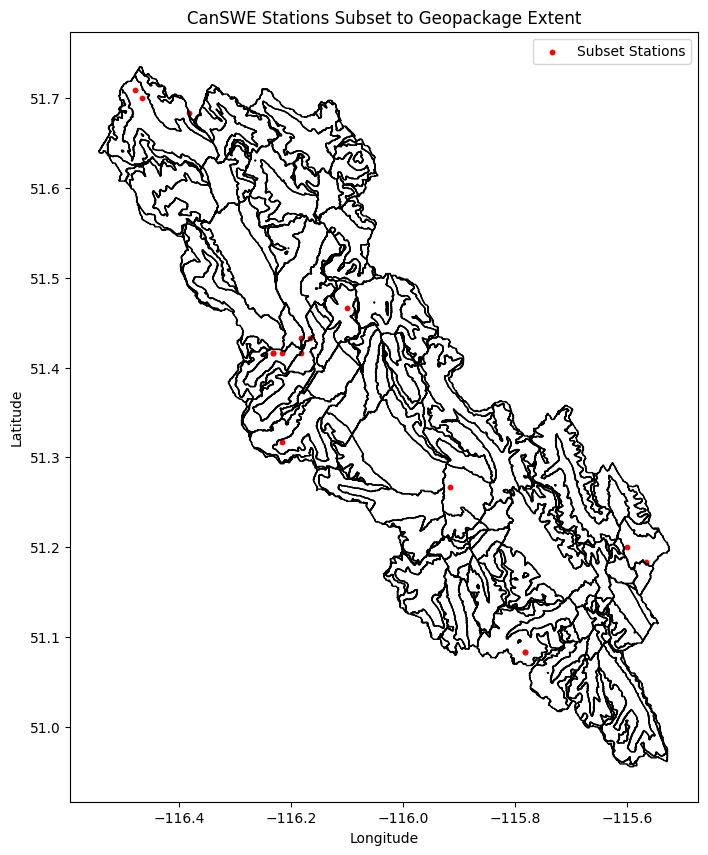

In [6]:
import xarray as xr
import geopandas as gpd
import pandas as pd
from shapely.geometry import Point, MultiPolygon
import matplotlib.pyplot as plt

# Load the CanSWE NetCDF dataset
canswe_dataset = xr.open_dataset('/Users/dcasson/Data/CanSWE/CanSWE-CanEEN_1928-2023_v6.nc')
extent_gdf = gpd.read_file('/Users/dcasson/Data/summa_snakemake/bow_above_banff/watershed_tools/final/bow_above_banff_elev_band.gpkg')

# Extract lat, lon, and station_id variables
lats = canswe_dataset['lat'].values
lons = canswe_dataset['lon'].values
station_ids = canswe_dataset['station_id'].values  # Assuming station_id is a variable

# Convert CanSWE stations to a GeoDataFrame
geometry = [Point(lon, lat) for lon, lat in zip(lons, lats)]
canswe_gdf = gpd.GeoDataFrame({'station_id': station_ids}, geometry=geometry, crs='EPSG:4326')

# Explode multi-part geometries to single-part geometries if necessary
if isinstance(extent_gdf.geometry.iloc[0], MultiPolygon):
    extent_gdf = extent_gdf.explode(index_parts=True)

# Initialize an empty GeoDataFrame for the subset
subset_gdf = gpd.GeoDataFrame(columns=canswe_gdf.columns, crs=canswe_gdf.crs)

# Perform the spatial join for each single-part geometry
for part in extent_gdf.geometry:
    temp_gdf = gpd.GeoDataFrame(geometry=[part], crs=extent_gdf.crs)
    temp_subset = gpd.sjoin(canswe_gdf, temp_gdf, how='inner', predicate='within')
    subset_gdf = pd.concat([subset_gdf, temp_subset], ignore_index=True)


# Plotting the result
fig, ax = plt.subplots(figsize=(10, 10))
extent_gdf.boundary.plot(ax=ax, color='black', linewidth=1)
subset_gdf.plot(ax=ax, color='red', markersize=10, label='Subset Stations')

plt.legend()
plt.title('CanSWE Stations Subset to Geopackage Extent')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

In [12]:
import geopandas as gpd
import xarray as xr
from shapely.geometry import Point

def read_and_convert_shapefile(shp_file):
    # Load the shapefile
    gdf = gpd.read_file(shp_file)
    
    # Ensure geometries are valid
    gdf['geometry'] = gdf['geometry'].apply(lambda geom: geom.buffer(0) if not geom.is_valid else geom)
    
    # Explode multi-part geometries into single-part geometries
    gdf = gdf.explode(index_parts=False)
    
    return gdf

def get_hru_ids(shp_file, nc_file):
    gdf = read_and_convert_shapefile(shp_file)
    
    ds = xr.open_dataset(nc_file)
    
    lats = ds['lat'].values
    lons = ds['lon'].values
    
    stations = gpd.GeoDataFrame({'latitude': lats, 'longitude': lons})
    stations['geometry'] = stations.apply(lambda row: Point(row['longitude'], row['latitude']), axis=1)
    stations.set_crs(epsg=4326, inplace=True)
    
    joined = gpd.sjoin(stations, gdf, how='left', op='within')
    
    hru_ids = joined['HRU_ID']

    
    #drop nan values
    hru_ids = hru_ids.dropna()
    # Add lat lon and station_name to the hru_ids
    hru_ids = hru_ids.to_frame()
    hru_ids['lat'] = lats[hru_ids.index]
    hru_ids['lon'] = lons[hru_ids.index]
    hru_ids['station_name'] = ds['station_name'].values[hru_ids.index]
    hru_ids['station_id'] = ds['station_id'].values[hru_ids.index]
    return hru_ids

canswe_dataset = '/Users/dcasson/Data/snow_data/NorSWE/NorSWE-NorEEN_1979-2021_v3.nc'
extent_gdf = '/Users/dcasson/Data/summa_snakemake/bow_tdx/watershed_tools/final/bow_tdx.gpkg'


hru_ids = get_hru_ids(extent_gdf,canswe_dataset)
# Export to csv
hru_ids.to_csv('/Users/dcasson/Data/summa_snakemake/bow_tdx/stations_with_hru_ids.csv')

/var/folders/46/6y3tkg051374dmsgd2w6l9gw0000gn/T/ipykernel_26997/3415108458.py:26: FutureWarning: You are adding a column named 'geometry' to a GeoDataFrame constructed without an active geometry column. Currently, this automatically sets the active geometry column to 'geometry' but in the future that will no longer happen. Instead, either provide geometry to the GeoDataFrame constructor (GeoDataFrame(... geometry=GeoSeries()) or use `set_geometry('geometry')` to explicitly set the active geometry column.
  stations['geometry'] = stations.apply(lambda row: Point(row['longitude'], row['latitude']), axis=1)
/Users/dcasson/.pyenv/versions/gpep_snakemake/lib/python3.10/site-packages/IPython/core/interactiveshell.py:3526: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [13]:
import xarray as xr
import matplotlib.pyplot as plt
import pandas as pd
from pathlib import Path
import numpy as np

def plot_swe_comparison(hru_id, start_date, end_date, swe_file, ensemble_files, aso_var = 'swe', summa_var='scalarSWE'):
    # Load the Tuolumne SWE data
    ds_swe = xr.open_dataset(swe_file)
    
    # Extract SWE data for the specified HRU and time period
    df_swe = ds_swe.sel(time=slice(start_date, end_date)).to_dataframe().reset_index()
    df_swe_hru = df_swe[df_swe['HRU_ID'] == hru_id]
    # Multiple swe variable by 1000
    if aso_var == 'swe':
        df_swe_hru[aso_var] = df_swe_hru[aso_var]*1000
    elif aso_var == 'snow_depth':
        df_swe_hru[aso_var] = df_swe_hru[aso_var]*1#0

    # Initialize a DataFrame to hold ensemble data
    df_ensemble = pd.DataFrame()

    # Load and process each ensemble file
    for idx, file in enumerate(ensemble_files):
        ds_ensemble_temp = xr.open_dataset(file)
        ds_swe_ensemble = ds_ensemble_temp[summa_var]
        df_ensemble_file = ds_swe_ensemble.sel(time=slice(start_date, end_date)).to_dataframe().reset_index()
        df_ensemble_file_hru = df_ensemble_file[df_ensemble_file['hru'] == hru_id]
        
        if df_ensemble.empty:
            df_ensemble = df_ensemble_file_hru[['time', summa_var]].rename(columns={summa_var: f'{summa_var}_{idx}'})
        else:
            df_ensemble = df_ensemble.merge(df_ensemble_file_hru[['time', summa_var]].rename(columns={summa_var: f'{summa_var}_{idx}'}), on='time', how='outer')

    
    # Convert ensemble data to numeric and handle NaN values
    df_ensemble.set_index('time', inplace=True)
    df_ensemble = df_ensemble.apply(pd.to_numeric, errors='coerce')
    ensemble_mean = df_ensemble.mean(axis=1).dropna()
    ensemble_max = df_ensemble.max(axis=1).dropna()
    ensemble_10th = df_ensemble.apply(lambda x: np.percentile(x.dropna(), 10), axis=1)
    ensemble_90th = df_ensemble.apply(lambda x: np.percentile(x.dropna(), 90), axis=1)

    # Ensure all indices are datetime
    ensemble_mean.index = pd.to_datetime(ensemble_mean.index)
    ensemble_max.index = pd.to_datetime(ensemble_max.index)
    ensemble_10th.index = pd.to_datetime(ensemble_10th.index)
    ensemble_90th.index = pd.to_datetime(ensemble_90th.index)
    df_swe_hru['time'] = pd.to_datetime(df_swe_hru['time'])

    # Plot the SWE data
    plt.figure(figsize=(14, 7))
    plt.scatter(pd.to_datetime(df_swe_hru['time']), pd.to_numeric(df_swe_hru[aso_var], errors='coerce'), label='SWE', color='black')
    
    # Plot the ensemble statistics
    plt.plot(ensemble_mean.index, ensemble_mean, label='Ensemble Mean', color='blue')
    plt.fill_between(ensemble_mean.index, ensemble_10th, ensemble_90th, color='blue', alpha=0.3, label='10th-90th Percentile')

    # Formatting the plot
    plt.xlabel('Date')
    plt.ylabel('SWE (mm)')
    plt.title(f'SWE Comparison for HRU {hru_id}')
    plt.legend()
    plt.grid(True)
    plt.show()


# File paths
#swe_file = '/Users/dcasson/Data/snow_data/tuolumne_lidar/tuolumne_swe_data.nc'
ensemble_files = Path('/Users/dcasson/Data/gpep/chena/summa_output/').glob('*.nc')
swe_file = '/Users/dcasson/Data/snow_data/NorSWE/Bow_NorSWE.nc'
#basin_gpkg_path = '/Users/dcasson/GitHub/PEMS/gis_data/bow/bow_boundary.gpkg'
# Example usage
plot_swe_comparison(hru_id=2601, start_date='2013-06-01', end_date='2018-12-31', swe_file=swe_file, ensemble_files=ensemble_files, aso_var = 'swe', summa_var='scalarSWE')

KeyError: 'HRU_ID'